# Fast Food Marketing Campaign A/B Testing

## About the dataset

### Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
The goal of this notebook is to evaluate the dataset using A/B Testing and determine which marketing strategy works best.

### Columns

- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

### Analysis Overview

- **Data Pre-processing**
- **Exploratory Data Analysis**
- **Checking test assumptions**
- **A/B test**
- **Consideration of confounding variables**
- **Conclusion**

## Methodology and Metric

The method of analysis used in this notebook is A/B testing. The latter is a form of Hypothesis testing, but specifically carried out to compare versions of a single variable to determine which version performs better based on a predefined metric/goal. Usually we use it to compare only two versions (A and B) hence the name A/B test, but in our dataset we have 3 different versions of the variable (marketing campaign for the new product). 

In this case, since there are 3 variants, we will use what is called **ANOVA (Analysis of Variance)** to determine which one of the three campaigns is better for advertising the new product. Considering the columns present in the dataset, the *metric* to be used will be **"SalesInThousands"** in that the better marketing strategy will provide the highest sales out of them all.

*The significance level for all of the hypothesis tests will be 5% (0.05).*

- The null hypothesis (H_0): There is no difference in the means of the three groups (i.e., the three marketing campaigns). 
- The alternative hypothesis (H_A): At least one of the means is different from the others. 

If we reject the null hypothesis, we can conclude that at least one of the marketing campaigns is more effective than the others.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
import warnings

warnings.filterwarnings("ignore")
pio.renderers.default = "svg"

In [2]:
df = pd.read_csv("datasets/WA_Marketing-Campaign.csv")

df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


### Data pre-processing

I will be checking the datatypes and converting them to more appropriate formats for the analysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


From the info table we can see that the data types for the "MarketID", "LocationID", "Promotion", "week" are integers. However, these columns contain infromation that makes more sense categorically then numerically. Therefore, I will convert them to categorical data. Furthermore, each column contains 548 data points, none of which are null.

In [4]:
for i in ["MarketID", "LocationID", "Promotion", "week"]:
    df[i] = df[i].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MarketID          548 non-null    category
 1   MarketSize        548 non-null    object  
 2   LocationID        548 non-null    category
 3   AgeOfStore        548 non-null    int64   
 4   Promotion         548 non-null    category
 5   week              548 non-null    category
 6   SalesInThousands  548 non-null    float64 
dtypes: category(4), float64(1), int64(1), object(1)
memory usage: 21.5+ KB


In [5]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

There are also no duplicate data in the dataset, which means that the information in each row is unique.

Now let's explore the two numerical columns we have, focusing first on AgeOfStore:

In [7]:
df[["AgeOfStore", "SalesInThousands"]].describe()

,AgeOfStore,SalesInThousands
count,548.000000,548.000000
mean,8.503650,53.466204
std,6.638345,16.755216
min,1.000000,17.340000
25%,4.000000,42.545000
50%,7.000000,50.200000
75%,12.000000,60.477500
max,28.000000,99.650000


Text(0, 0.5, 'Count')

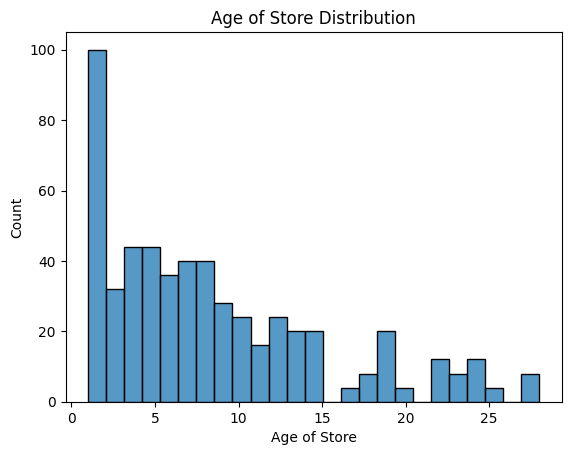

In [8]:
sns.histplot(df["AgeOfStore"], bins=df.AgeOfStore.nunique(), stat="count")
plt.title("Age of Store Distribution")
plt.xlabel("Age of Store")
plt.ylabel("Count")

From the description table and the histplot above, I would say that the AgeOfStore does not really seem to provide any useful information for us as a numerical variable. To know more, I will need to see if there is any correlation between this column and the SalesInThousands column:

Text(0, 0.5, 'Sales in Thousands')

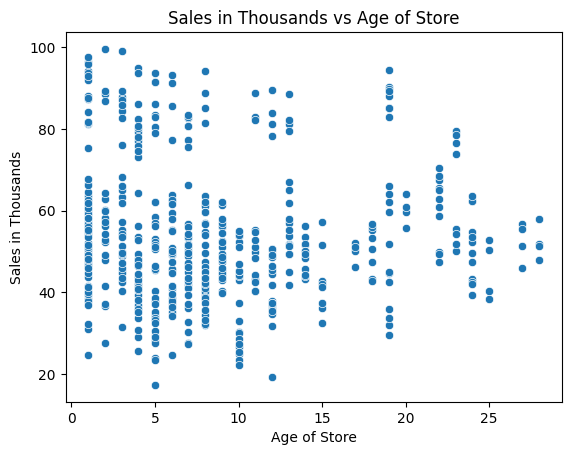

In [9]:
sns.scatterplot(data=df, x="AgeOfStore", y="SalesInThousands")
plt.title("Sales in Thousands vs Age of Store")
plt.xlabel("Age of Store")
plt.ylabel("Sales in Thousands")

In [10]:
stats.pearsonr(df.AgeOfStore, df.SalesInThousands)

PearsonRResult(statistic=np.float64(-0.028532881102495675), pvalue=np.float64(0.5050607939715022))

From both the scatterplot and pearson correlation test above, we can see that it is highly unlikely that the age of the store is correlated with the sales. Therefore, it would be better to consider the store age not as a numerical variable but rather as a categorical one, where we group the stores in 3 age categories new, mature, and old stores:

In [11]:
df["store_age"] = pd.qcut(df.AgeOfStore, 3, labels=["new", "mature", "old"])

## EDA

In this section, I will focus on understanding the variables both individually and comparatively (Avarage sales by age group, Avarage sales by promotion strategy, Avarage sales by MarketSize). 

I will also perform a chi squared test to understand if there is any sample ratio mismatch (SRM) in the three promotion variances considering the distribution of the datapoints within the 3 groups.

In [12]:
promo_count = (df.Promotion.value_counts(normalize=True) * 100).reset_index()
promo_count.columns = ["Promotion", "Percentage"]
promo_count.Percentage = promo_count.Percentage.round(2)
promo_count.sort_values("Promotion", inplace=True)

px.bar(
    promo_count,
    x="Promotion",
    y="Percentage",
    text="Percentage",
    title="Promotion Distribution",
)

In [13]:
stats.chisquare(df.groupby("Promotion")["SalesInThousands"].count())
# p-value bigger than 0.05 therefore there is no significant SRM detected.

Power_divergenceResult(statistic=np.float64(0.9343065693430658), pvalue=np.float64(0.6267840066678985))

The barplot and chi2 test above show that there is no significant SRM and all three variants are almost equally represented in the dataset, so we can confidently say that our sample is balanced.

Next I would like to analyse the distribution of the metric itself, the sales in thousands column:

<Axes: ylabel='SalesInThousands'>

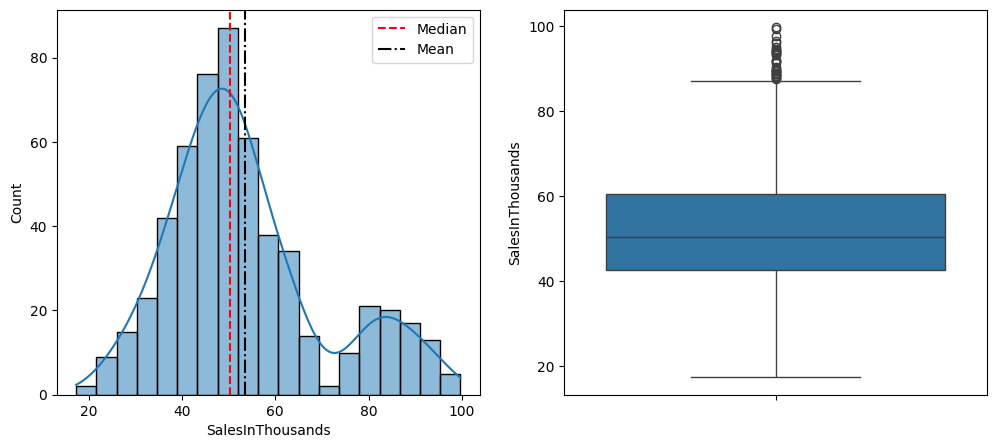

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df, x="SalesInThousands", ax=ax1, kde=True)
ax1.axvline(df.SalesInThousands.median(), color="red", ls="--", label="Median")
ax1.axvline(df.SalesInThousands.mean(), color="black", ls="-.", label="Mean")
ax1.legend()

sns.boxplot(data=df, y="SalesInThousands", ax=ax2)

From the histogram above, we can see that Sales in Thousands does not follow a normal distribution (it resembles a bimodal distribution). The boxplot suggests that there is a considerable amount of outlier data as well.

In [15]:
df.groupby("store_age").SalesInThousands.mean().reset_index()
px.bar(
    df.groupby("store_age").SalesInThousands.mean().reset_index(),
    y="SalesInThousands",
    x="store_age",
    title="Sales in Thousands by Store Age",
    text="SalesInThousands",
).update_traces(texttemplate="%{text:.2f}").update_layout(
    xaxis_title="Store Age",
    yaxis_title="Sales in Thousands",
    title_x=0.5,
)

From the plot above, the average sales seem to be also fairly similar along the 3 store age categories. However, if we take into consideration the distribution of store ages in the previous section, it would be a smart decision to consider the age groups as a confounding variable for our analysis.

In [16]:
promo_sales = (
    df.groupby(["Promotion", "MarketSize"]).SalesInThousands.mean().reset_index()
)

fig = px.bar(
    promo_sales,
    x="Promotion",
    y="SalesInThousands",
    color="MarketSize",
    text="SalesInThousands",
    title="Average Sales by Promotion per Market Size",
)

fig.update_traces(texttemplate="%{text:.2f}").update_layout(
    xaxis_title="Promotion",
    yaxis_title="Sales in Thousands",
    title_x=0.5,
    barmode="group",
)

From the plot above we can see that the average sales tend to be higher in small and large market sizes, but lower in the medium ones. Therefore, we need to consider Market size as a confounding variable in our analysis later on.

## Checking Test assumptions

In this section I will be checking if our dataset fulfills the three assumptions of the ANOVA test:
- The data is normally distributed.
- The variance among the groups should be homogenous (approximately equal).
- The observations are independent of each other.

Depending on whether the assumption are met or not, I will decide wich method of testing is appropriate for the dataset in question.

Text(0.5, 0, 'Sales in Thousands')

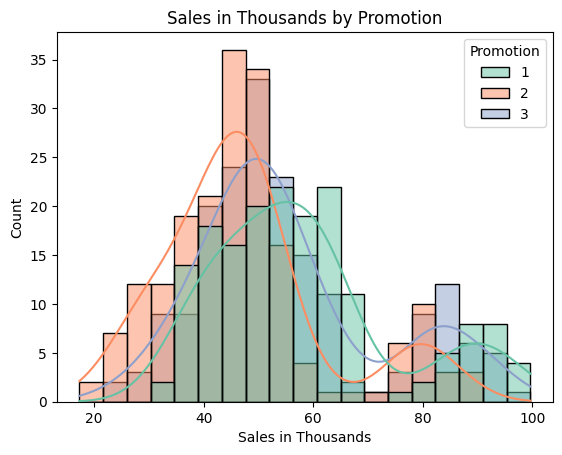

In [17]:
sns.histplot(df, x="SalesInThousands", hue="Promotion", kde=True, palette="Set2")
plt.title("Sales in Thousands by Promotion")
plt.xlabel("Sales in Thousands")

As we can see from the histogram of the sales distrbitutions by platform above, neither of the 3 distributions are normal. Thus, **the assumption of normality is not met**.

From the shape of the three distributions, however, we can notice that there is not much variance between the three distributions, yet a Levene test will be able to quantify this claim for a definite answer. The levene test is a hypothesis test such that:
- H_0: The variances of all groups are equal.
- H_A: At least one group's vairance differs from the rest.

After carrying out this test, if the p-value obtained is not significant (>0.05) then we have no evidence that the variances of all the groups present any difference.

In [18]:
sales_per_promotion = [
    df[df.Promotion == x].SalesInThousands for x in df.Promotion.unique()
]
levene = stats.levene(*sales_per_promotion)
levene

LeveneResult(statistic=np.float64(1.2696787527507418), pvalue=np.float64(0.2817514565692118))

From the result above (p-value = 0.28 > 0.05) we can confidently say that the variances are homogeneous. Thus, **the homogenity of variances conditions is met**.

**The condition of independence is also met** because the sales data was roughly evenly split for each promotion strategy, having a different LocationID, MarketSize, etc. (essentially there are no duplicates in the dataset, so the rows/data are independent).

In [19]:
df.groupby("LocationID").SalesInThousands.mean().duplicated().sum()

np.int64(0)

Since one of our assumptions is violated (the assumption of normality), we cannot perform an ANOVA test. In this case, we would need to perform a non-parametric test instead. 

A non-parametric test that does not require normality and is usually used to compare three or more variants, is the **Kruskal-Wallis Test**. There is a function in the scipy.stats library that conducts the test and offers the results to us.

## A/B test

As established earlier, the test that we would need to carry out is the Kruskal-Wallis Test. This test compares the distributions (the medians) of 3 or more independent groups (like in this case). The hypothesis raised are as follows:
- H_0: The medians of the groups are the same (thus the data comes from the same distribution).
- H_A: At least one median differs from the rest (at least one group comes from a different distribution).

If in fact we reject H_0, we would also need to then individually compare the medians and run tests to determine a ranking of the three promotion strategies. Again for pariwize comparison, since the distributions are not normal, we would need to use a non-parametric test. 

In such a case, I would use the **Kolmogorov-Smirnov Test** which compares the cumulative distribution functions of two samples (or one sample to a reference probability).

First let's run the Kruskal-Wallis test:

In [20]:
k = stats.kruskal(*sales_per_promotion)
k.pvalue

np.float64(2.6741866266697816e-12)

The resulting pvalue of the Kruskal test above leads us to reject the null hypothesis, as it is much smaller than the 5% significance level. Therefore, we can safely assume that at least one promotion strategy has better sales than the rest (or there could be a ranking of the three).

Since the test failed, I will procede with the pairwize comparison of the three groups using the KS test to understand if there could be a ranking system or not. In this test the two hypothesis are:

- H_0: the data of the two groups comes from the same continuous distribution.
- H_A: the data comes from different distributions.

In [21]:
comp_table = MultiComparison(df.SalesInThousands, df.Promotion)
result = comp_table.allpairtest(stats.ks_2samp, alpha=0.05)

result[0]

group1,group2,stat,pval,pval_corr,reject
1,2,0.3696,0.0,0.0,True
1,3,0.1665,0.0117,0.0352,True
2,3,0.2606,0.0,0.0,True


In the table of results above the null hypothesis is rejected in all three cases. Which means that there is a difference between all three groups, and therefore there must be a ranking. To determine the ranking I would like to visualize the data using a boxplot that shows where the medians stand next to each other.

<Axes: xlabel='Promotion', ylabel='SalesInThousands'>

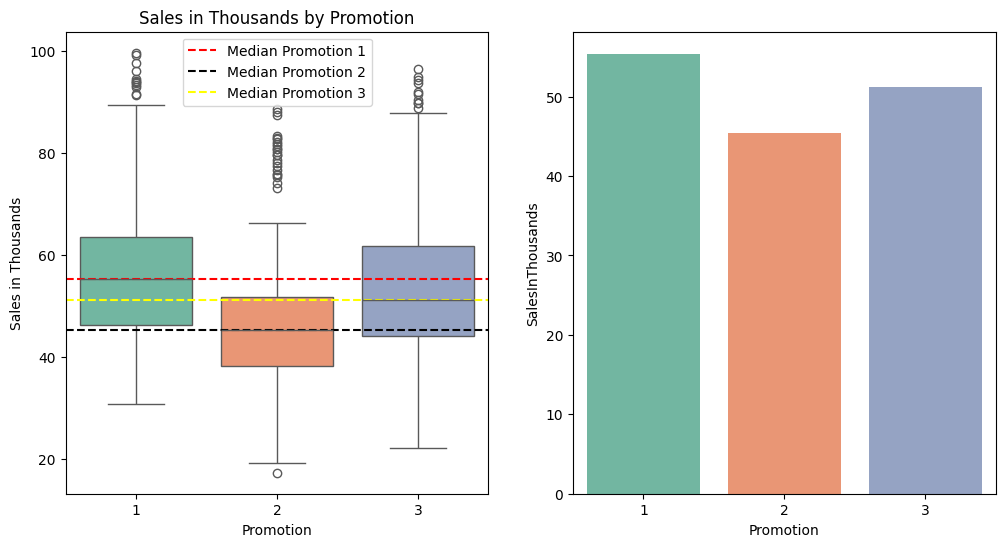

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.boxplot(df, x="Promotion", y="SalesInThousands", palette="Set2")

plt.title("Sales in Thousands by Promotion")
plt.xlabel("Promotion")
plt.ylabel("Sales in Thousands")

m1, m2, m3 = df.groupby("Promotion")["SalesInThousands"].median().values

plt.axhline(m1, color="red", ls="--", label="Median Promotion 1")
plt.axhline(m2, color="black", ls="--", label="Median Promotion 2")
plt.axhline(m3, color="yellow", ls="--", label="Median Promotion 3")
plt.legend()

plt.subplot(122)
sns.barplot(
    data=df,
    x="Promotion",
    y="SalesInThousands",
    palette="Set2",
    estimator=np.median,
    ci=None,
)

From the figure above, I can see that in our sample there seems to be a ranking order as follows: 
- promotion 1 > promotion 3 > promotion 2

Since, the tests above confirmed both the difference of variants and the presence of a ranking between these variants, I have reason to believe the ranking above is generalizable. Therefore, promotion strategy nr. 1 would be the one that generated the most sales and thus the most successful, followed by strategy nr. 3, while  nr. 2 generated the least sales.

Let's check these findings using CIs computed analyitcally:

In [23]:
CI = comp_table.tukeyhsd()
CI.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


Let's check the CI via bootstrapping:

In [24]:
def bootstrap_ci(group1, group2, nboot=1000, alpha=0.05):
    """
    Bootstrap confidence interval for the difference in means between two groups.
    Parameters:
    group1: array-like, first group of data
    group2: array-like, second group of data
    nboot: int, number of bootstrap samples
    alpha: float, significance level for the confidence interval
    Returns:
    tuple: lower and upper bounds of the confidence interval
    """
    boot_diffs = []
    for _ in range(nboot):
        # Resample with replacement
        boot1 = np.random.choice(group1, size=len(group1), replace=True)
        boot2 = np.random.choice(group2, size=len(group2), replace=True)
        boot_diffs.append(np.mean(boot1) - np.mean(boot2))

    # Calculate percentile-based CI
    lower = np.percentile(boot_diffs, 100 * alpha / 2)
    upper = np.percentile(boot_diffs, 100 * (1 - alpha / 2))
    return (lower, upper)


groups = df.groupby("Promotion")["SalesInThousands"].apply(list)
promo1 = groups[1]
promo2 = groups[2]
promo3 = groups[3]

comparisons = {
    "1 vs 2": bootstrap_ci(promo1, promo2),
    "1 vs 3": bootstrap_ci(promo1, promo3),
    "2 vs 3": bootstrap_ci(promo2, promo3),
}

pd.DataFrame(comparisons).T.rename(columns={0: "Lower Bound", 1: "Upper Bound"})

,Lower Bound,Upper Bound
1 vs 2,7.549319,14.172038
1 vs 3,-0.513410,6.177813
2 vs 3,-11.246044,-4.690395


Using both the analytical and bootstrapping method of producing confidence intervals we can see that when comparing the metric between Promotions 1vs2 and 2vs3, we obtain Confidence intervals that do not include 0. Thus, the null hypothesis (that the means of the two groups come from the same distribution) is rejected. 

However, that is not the case when we compare Promotions 1 and 3, which contradicts our earlier finding using the non-parametric test. Giving a closer look to the bootstrapping method (which is more robust than the analytical computation for this case), we can see that 0 is thinly included in the CI. This makes me more inclined to believe the results of the Kolmogorov-Smirnov test, which suggested that there is a difference between the two groups.

## Confounding variables

The result above only takes into account the metric (sales) and the variable in question (promotion), however it fails to take into account any difference that could occur from other variables in the dataset such as Market size, week, and Age of store.

To determine the presence of a confounding variable I will check if there is any visual difference between the independent variable and the dependent variable (metric/sales) while adding the suspected confounder as a hue, and hue-ing the confounder by the independent variable (Promotion). 

Then I will confirm numerically by checking the pvalue of a fischer_exact test between the independent variable (promotion) and the confounder (if the variables are independent of the confounder or not).

In [25]:
def find_confounder(df, confounder, x="Promotion") -> np.float64:
    """
    Function to find confounders in the data
    """
    contingency_table = pd.crosstab(df[x], df[confounder])

    _, p = stats.fisher_exact(contingency_table)

    return p


def visualize_confounder(df, confounder, x="Promotion", y="SalesInThousands") -> None:
    """
    Function to visualize confounders in the data
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"Suspected confounder: {confounder}")

    sns.barplot(df, x=x, y=y, ax=ax1, estimator="median", palette="Set2")
    ax1.set_title(f"Without the confounder")

    sns.barplot(
        df, x=x, y=y, hue=confounder, ax=ax2, estimator="median", palette="Set2"
    )
    ax2.set_title(f"Hue-ed by {confounder}")

    sns.barplot(
        df, x=confounder, y=y, hue=x, ax=ax3, estimator="median", palette="Set2"
    )
    ax3.set_title(f"{confounder} hue-ed by {x}")
    plt.show()

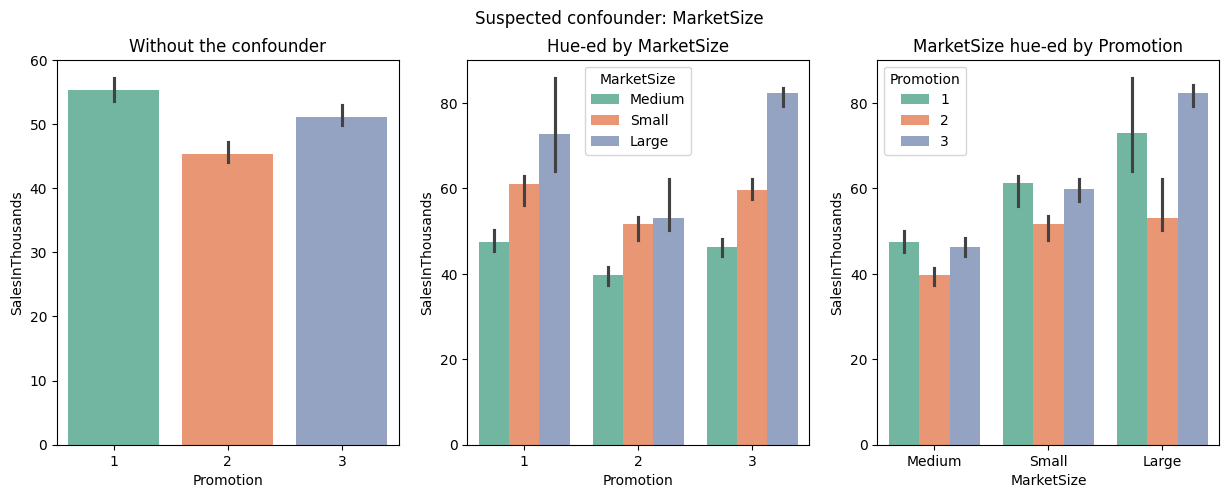

np.float64(0.2972)

In [26]:
visualize_confounder(df, "MarketSize")
find_confounder(df, "MarketSize")

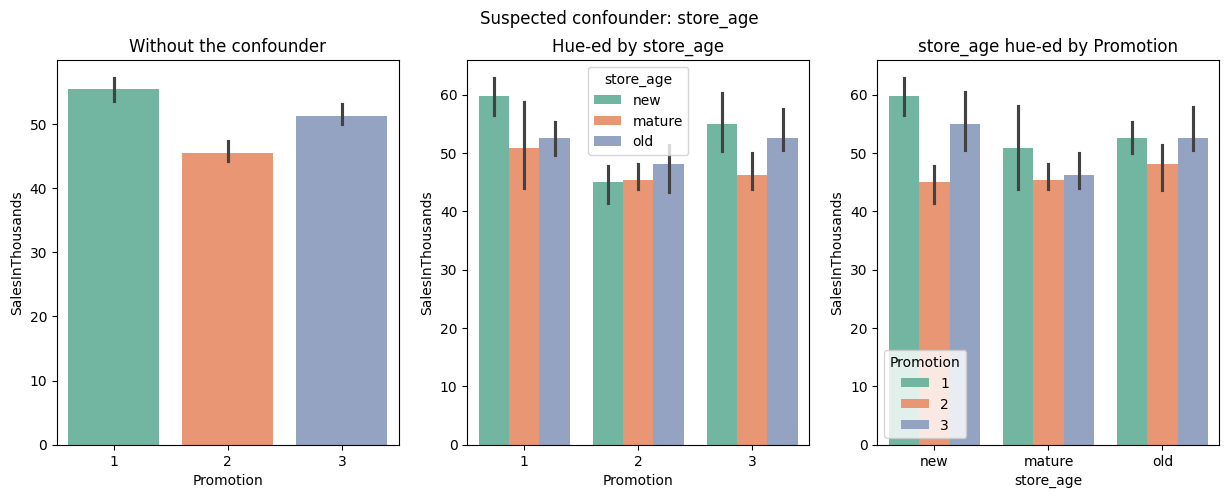

np.float64(0.1438)

In [27]:
visualize_confounder(df, "store_age")
find_confounder(df, "store_age")

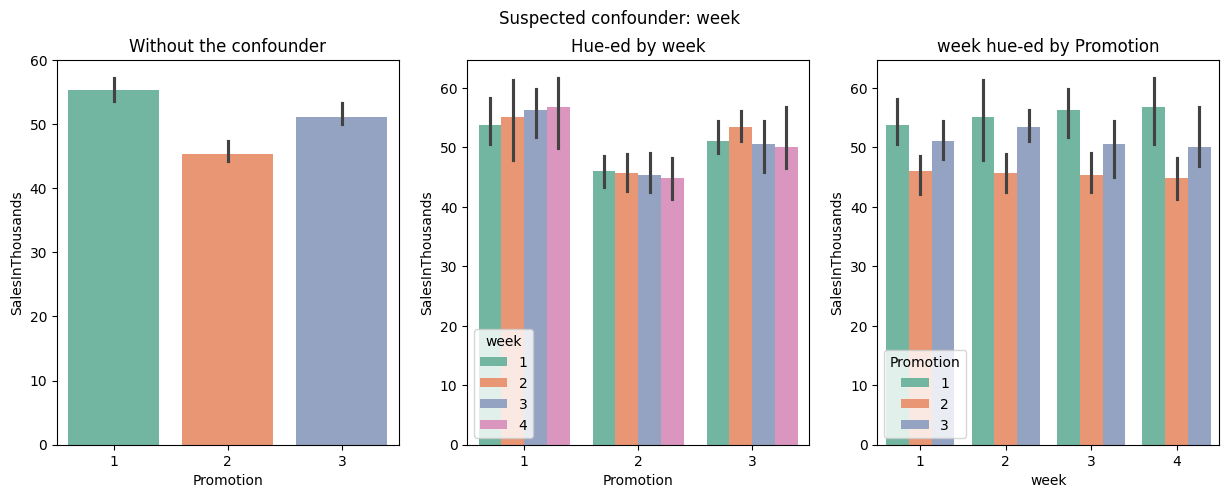

np.float64(1.0)

In [28]:
visualize_confounder(df, "week")
find_confounder(df, "week")

From the visual results, we can see that all of the figures using the confounder as a hue, and those using promotion as a hue to the confounder, show pretty consistent results. 

Without any noticeable visual discrepancies, I turned to the fisher exact test's pvalues and all of them are above the significance level of 5%. Therefore, there is no actual confounders in the dataset that would affect the general promotion strategy ranking.

# Conclusions & Summary

### Overview
This analysis evaluated the effectiveness of three different marketing campaigns for a new menu item at a fast-food chain. The study used A/B testing methodology with sales data collected across multiple store locations over four weeks.

### Key Findings

1. **Campaign Performance**
    - Promotion Strategy 1 demonstrated the highest sales performance
    - Promotion Strategy 3 showed moderate sales results
    - Promotion Strategy 2 had the lowest sales impact

2. **Statistical Validation**
    - Analysis used non-parametric tests (Kruskal-Wallis and Kolmogorov-Smirnov)
    - Results showed statistically significant differences between all three promotions
    - Data integrity was confirmed through balanced sampling across promotions

3. **Environmental Factors**
    - No significant impact from:
      - Market size variations
      - Store age differences
      - Timing of promotions (weeks)
    - Results were consistent across different store conditions

### Recommendation
Based on clear statistical evidence, Promotion Strategy 1 is recommended for implementing the new menu item launch, as it consistently delivered superior sales performance across all market conditions.